In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [ ]:
input_data = './mask_dataset'
output_data = './yolov7/data'
annotations_path = input_data + '/annotations'
images_path = input_data + '/images'

### Dataset structure

In [ ]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

### Adding filenames and their annotations to the dictionary

In [ ]:
for anno in glob.glob(annotations_path+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

### Convert dictionary to dataframe and add class column

In [ ]:
df = pd.DataFrame(dataset)

name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}
df['class'] = df['name'].map(name_dict)

df.head(10)

file                   name  width  height  xmin  ymin  xmax  \
0  maksssksksss165              with_mask    450     463    15   111   114   
1  maksssksksss165              with_mask    450     463   324   135   410   
2  maksssksksss640              with_mask    400     210    21    48    77   
3  maksssksksss640              with_mask    400     210   118    84   163   
4  maksssksksss640              with_mask    400     210   157   113   189   
5  maksssksksss640              with_mask    400     210   172    65   202   
6  maksssksksss640              with_mask    400     210   195   103   240   
7  maksssksksss640              with_mask    400     210   260   129   302   
8  maksssksksss640              with_mask    400     210   283    42   314   
9  maksssksksss640  mask_weared_incorrect    400     210   364    84   399   

   ymax  class  
0   219      0  
1   238      0  
2   104      0  
3   131      0  
4   146      0  
5    95      0  
6   150      0  
7   173      0  
8    71      0  
9   121      1

### Split to train, test, and validation

In [ ]:
# List all images in the images folder
images = [*os.listdir(images_path)]

# Split dataset | %90 train , %7 test , %3 validation
train, test = train_test_split(images, test_size=0.1, random_state=7)
test, val = train_test_split(test, test_size=0.7, random_state=7)

### Resize and copy the images to separate folders

In [ ]:
# Create separate folders for train, test, and validation images and annotations
os.mkdir(output_data+'/train')
os.mkdir(output_data+'/test')
os.mkdir(output_data+'/val')
os.mkdir(output_data+'/train/images')
os.mkdir(output_data+'/train/labels')
os.mkdir(output_data+'/test/images')
os.mkdir(output_data+'/test/labels')
os.mkdir(output_data+'/val/images')
os.mkdir(output_data+'/val/labels')

width = 640
height = 480

def copyImages(imageList, folder_Name):
    for image in tqdm(imageList):
        img = Image.open(input_data+'/images/'+image)
        resized_img = img.resize((width, height))
        _ = resized_img.save(output_data+'/'+folder_Name+'/images/'+image)

copyImages(train, 'train')
copyImages(val, 'val')
copyImages(test, 'test')

### Rescale mask annotations to match the resized images

In [ ]:
df['xmax'] = (width/df['width'])*df['xmax']
df['ymax'] = (height/df['height'])*df['ymax']
df['xmin'] = (width/df['width'])*df['xmin']
df['ymin'] = (height/df['height'])*df['ymin']

### Add mask box height, width, and center

In [ ]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [ ]:
df['class'].value_counts(normalize=True)

In [ ]:
import seaborn as sns
sns.countplot(x=df["class"])

### Create labels files

In [ ]:
df = df.astype('string')

def create_labels(image_list, dataset):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+' '+row['x_center']+' '+row['y_center']\
                        +' '+row['box_height']+' '+row['box_width'])
            
        text = '\n'.join(box_list)
        with open(output_data+'/'+dataset+'/labels/'+name+'.txt', 'w') as file:
            file.write(text)


create_labels(train, 'train')
create_labels(val, 'val')
create_labels(test, 'test')

### Create yaml file for YOLO

In [ ]:
yaml_text = '''
train: yolov7/data/train/images
val: yolov7/data/val/images
test: yolov7/data/test/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']
'''

with open('./yolov7/data/data.yaml', 'w') as file:
    file.write(yaml_text)

# Model training

In [ ]:
!python ./yolov7/train.py --img 640 --batch 2 --epochs 50 --data ./yolov7/data/data.yaml --cfg ./yolov7/cfg/training/yolov7x.yaml --weights ./yolov7/yolov7x.pt --name yolov7x_results  --cache

YOLOR 🚀 2022-10-8 torch 1.9.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060, 5926.6875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=2, bbox_interval=-1, bucket='', cache_images=True, cfg='./yolov7/cfg/training/yolov7x.yaml', data='./yolov7/data/data.yaml', device='', entity=None, epochs=50, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='./yolov7/data/hyp.scratch.p5.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov7x_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov7x_results8', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=2, upload_dataset=False, v5_metric=False, weights='./yolov7/yolov7x.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_d

 95                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
 96                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
 97                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
 98                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
 99                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
100                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
101[-1, -3, -5, -7, -8]  1         0  models.common.Concat                    [1]                           
102                -1  1    410240  models.common.Conv                      [1280, 320, 1, 1]             
103                -1  1         0  models.common.MP                        []                            
104                -1  1    103040 

     10/49     3.31G   0.03244   0.01287  0.005771   0.05108        28       640
               Class      Images      Labels           P           R      mAP@.5
                 all          61         376       0.855       0.444       0.488       0.295

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
     11/49     3.31G   0.03098   0.01226  0.005757     0.049         1       640
               Class      Images      Labels           P           R      mAP@.5
                 all          61         376       0.831       0.481        0.52       0.331

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
     12/49     3.31G   0.03097   0.01267   0.00522   0.04886         2       640
               Class      Images      Labels           P           R      mAP@.5
                 all          61         376       0.854       0.446       0.502       0.305

     Epoch   gpu_mem       box       obj       cls     total    labels

               Class      Images      Labels           P           R      mAP@.5
                 all          61         376       0.578       0.656       0.642        0.42

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
     35/49     3.31G   0.02359   0.01065  0.003274    0.0375         2       640
               Class      Images      Labels           P           R      mAP@.5
                 all          61         376       0.542       0.675       0.649       0.436

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
     36/49     3.31G   0.02291   0.01026  0.003493   0.03666        10       640
               Class      Images      Labels           P           R      mAP@.5
                 all          61         376       0.585       0.669       0.651       0.433

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
     37/49     3.31G   0.02268   0.01006  0.003187   0.03593         3

# Evaluation

In [ ]:
!python ./yolov7/test.py --weights ./runs/train/yolov7x_results8/weights/best.pt --data ./yolov7/data/data.yaml

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./yolov7/data/data.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='exp', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', v5_metric=False, verbose=False, weights=['./runs/train/yolov7x_results8/weights/best.pt'])
YOLOR 🚀 2022-10-8 torch 1.9.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060, 5926.6875MB)

Fusing layers... 
IDetect.fuse
Model Summary: 362 layers, 70795920 parameters, 0 gradients
 Convert model to Traced-model... 
/home/abdulaziz/anaconda3/envs/w2v/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding

In [ ]:
!python ./yolov7/detect.py --source ./yolov7/data/test/images --weight ./runs/train/yolov7x_results8/weights/best.pt --conf 0.5 --name test_images  --no-trace

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='test_images', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='./yolov7/data/test/images', update=False, view_img=False, weights=['./runs/train/yolov7x_results8/weights/best.pt'])
YOLOR 🚀 2022-10-8 torch 1.9.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060, 5926.6875MB)

Fusing layers... 
IDetect.fuse
Model Summary: 362 layers, 70795920 parameters, 0 gradients
 Convert model to Traced-model... 
/home/abdulaziz/anaconda3/envs/w2v/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
!python ./yolov7/detect.py --source ./yolov7/data/test/Test_extra --weight ./runs/train/yolov7x_results8/weights/best.pt --conf 0.7 --name Test_extra  --no-trace

## Confusion matrix

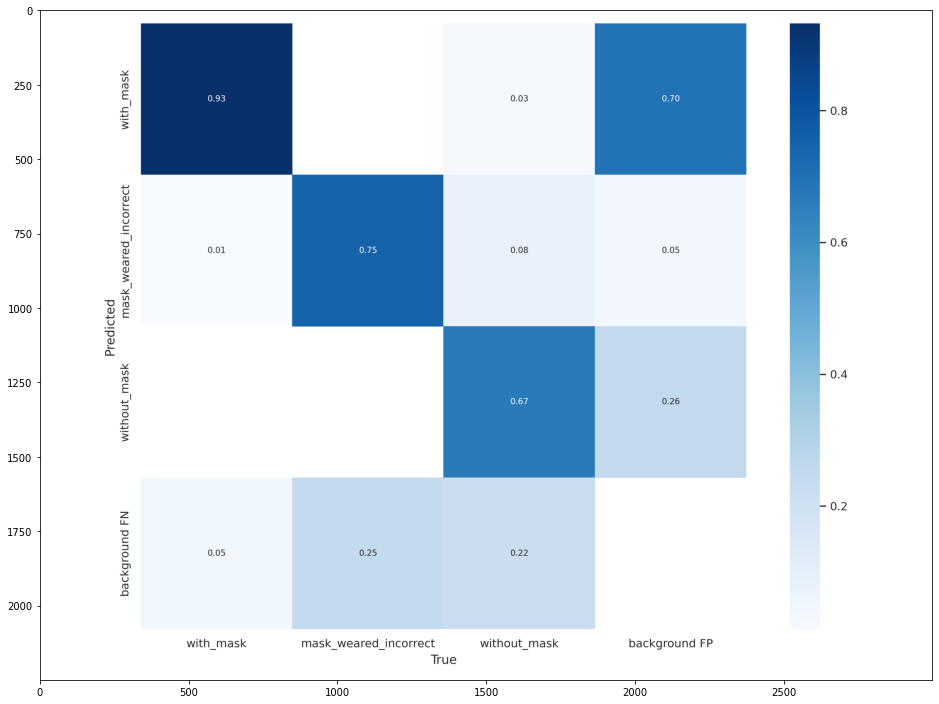

In [ ]:
img = mpimg.imread('runs/test/exp/confusion_matrix.png')
plt.figure(figsize=(16,16))
imgplot = plt.imshow(img)
plt.show()

## F1 curve

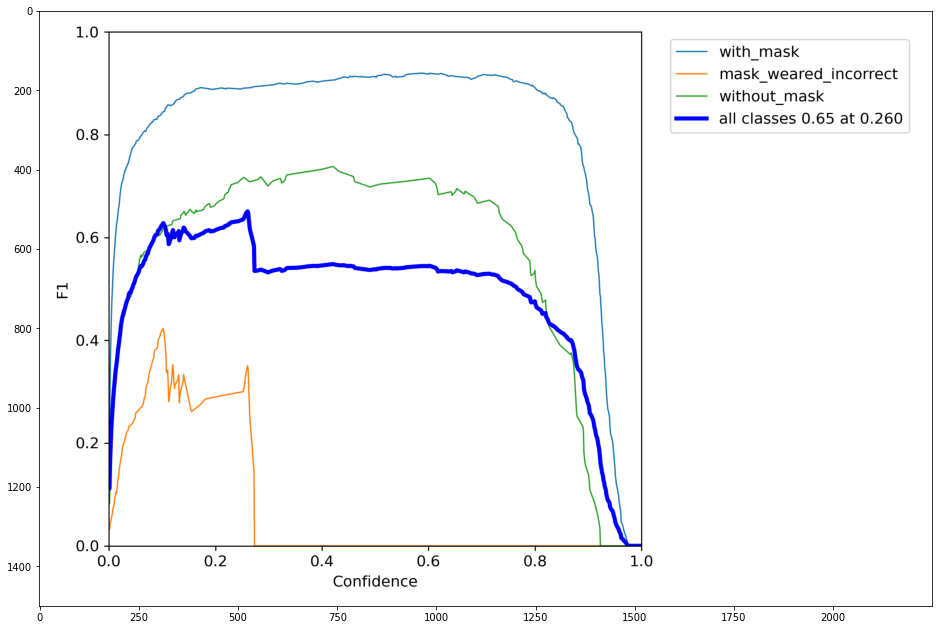

In [ ]:
img = mpimg.imread('runs/test/exp/F1_curve.png')
plt.figure(figsize=(16,16))
imgplot = plt.imshow(img)
plt.show()

## Precision curve

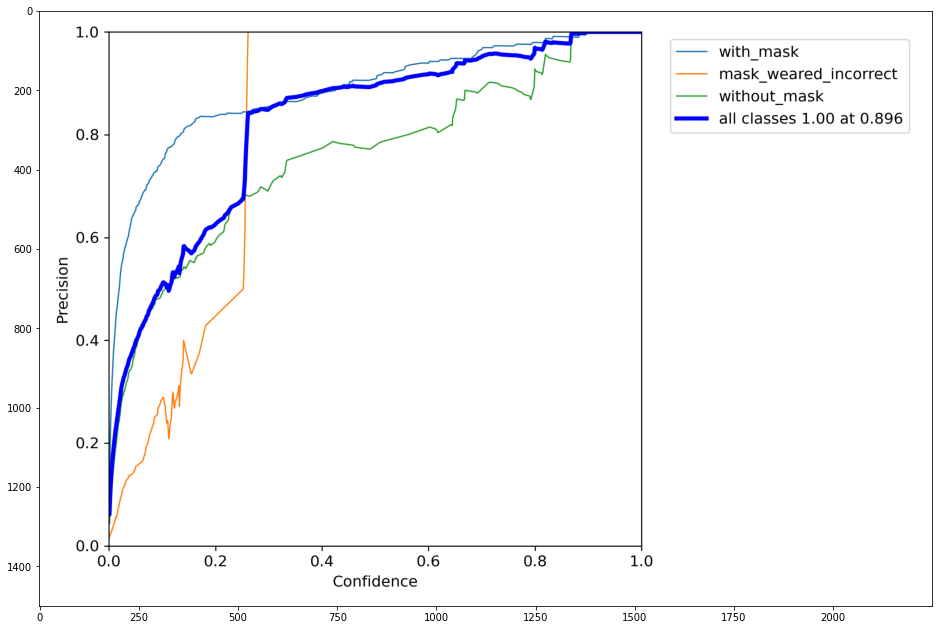

In [ ]:
img = mpimg.imread('runs/test/exp/P_curve.png')
plt.figure(figsize=(16,16))
imgplot = plt.imshow(img)
plt.show()

## Precision-Recall curve

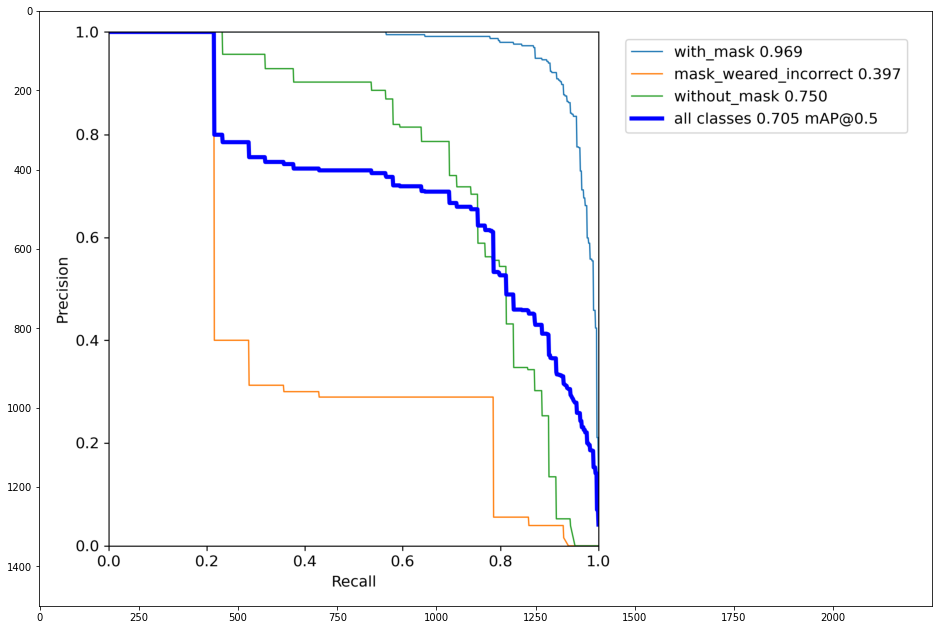

In [ ]:
img = mpimg.imread('runs/test/exp/PR_curve.png')
plt.figure(figsize=(16,16))
imgplot = plt.imshow(img)
plt.show()

## Recall curve

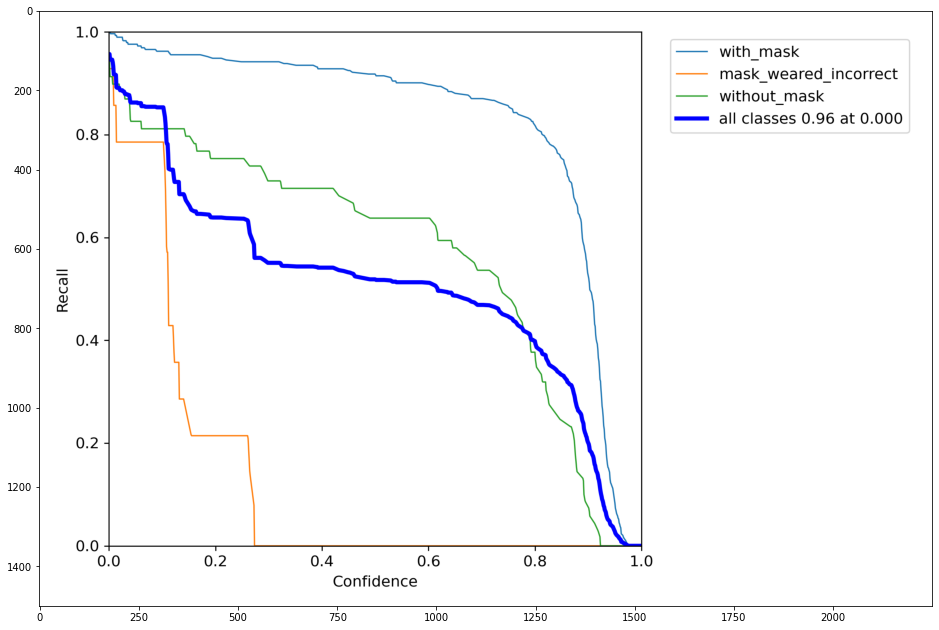

In [ ]:
img = mpimg.imread('runs/test/exp/R_curve.png')
plt.figure(figsize=(16,16))
imgplot = plt.imshow(img)
plt.show()

# Test on images

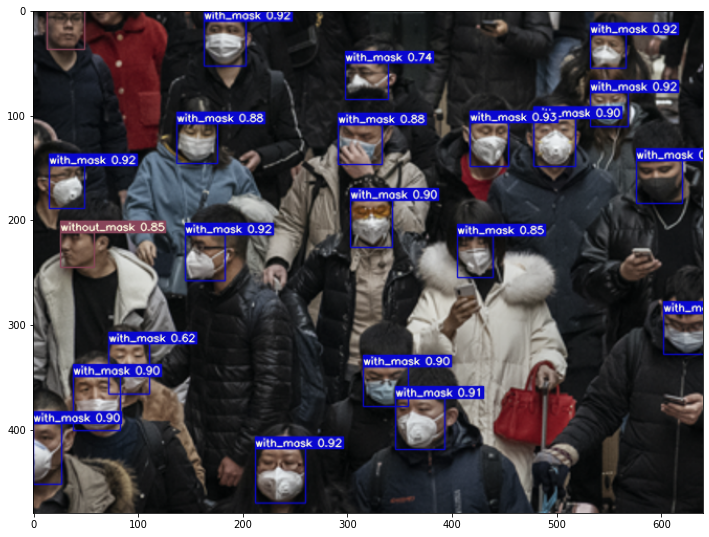

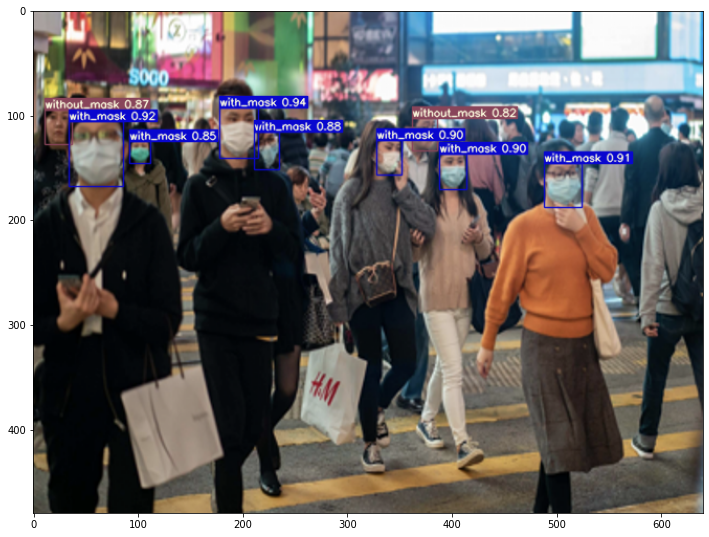

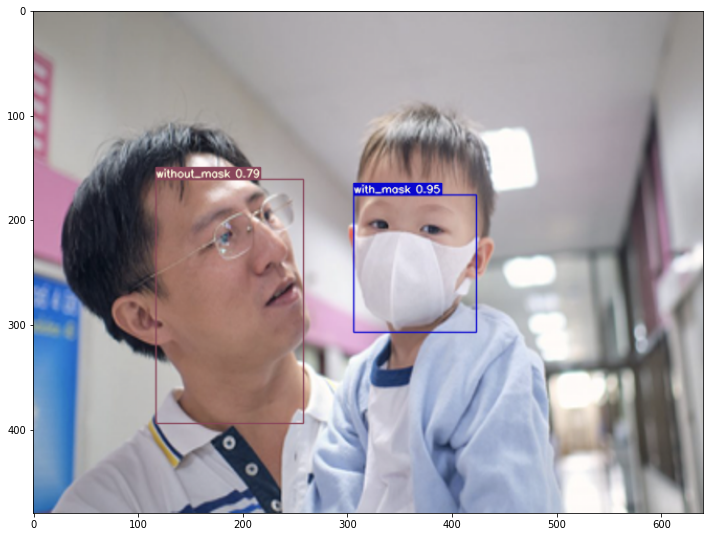

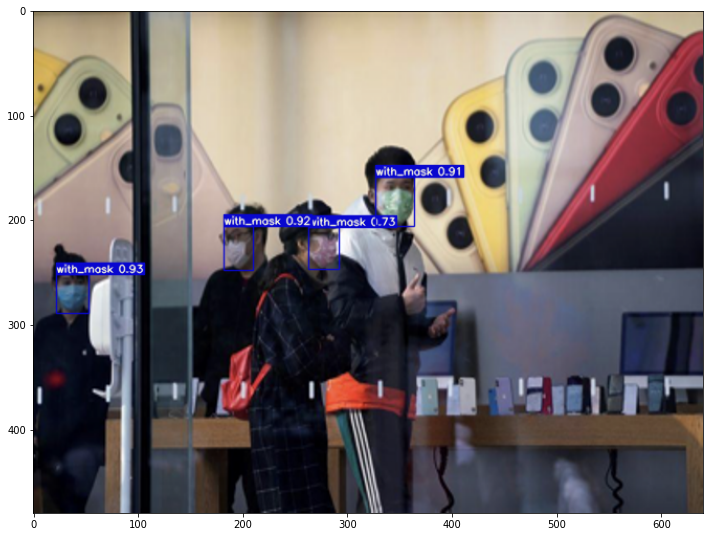

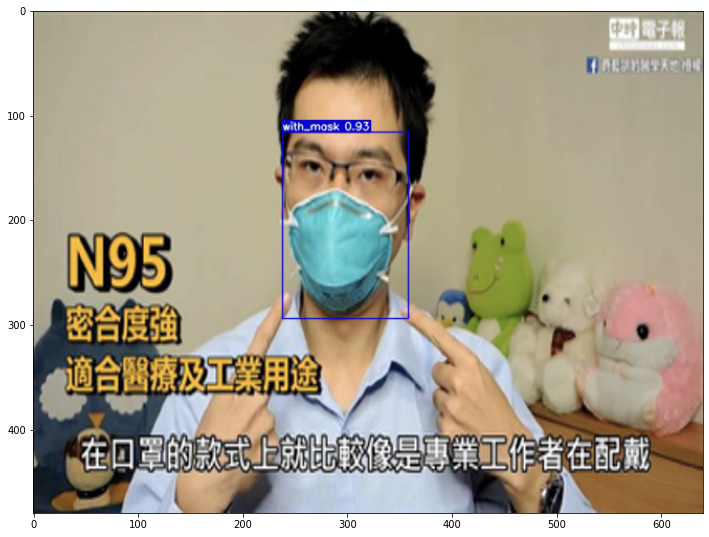

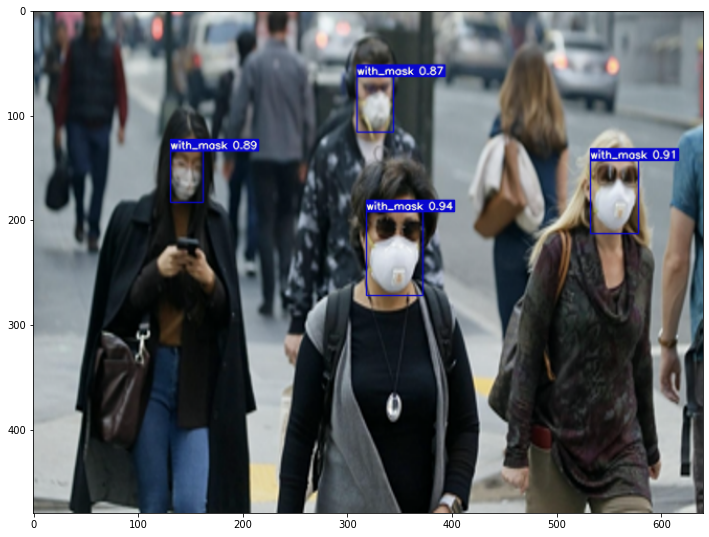

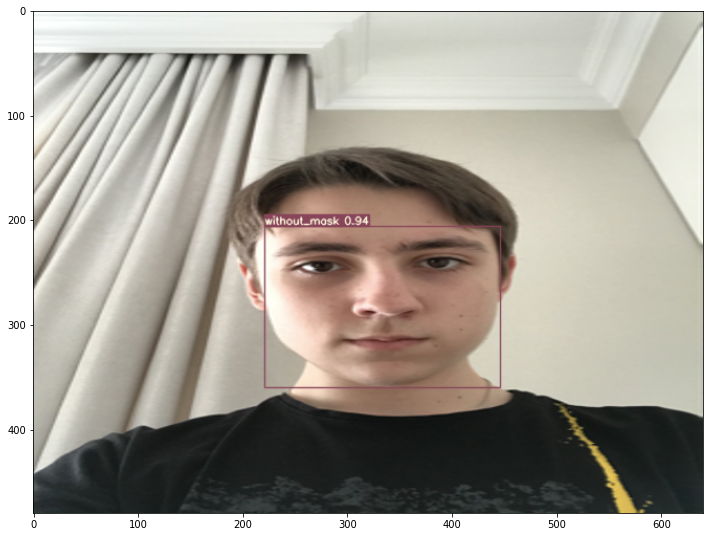

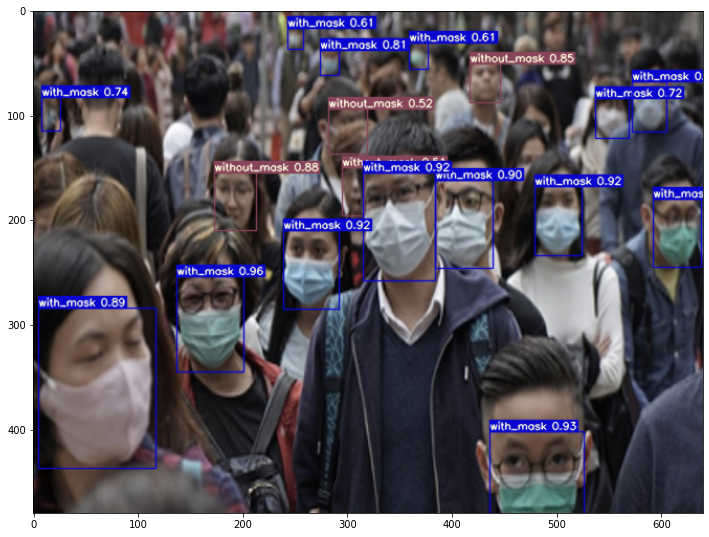

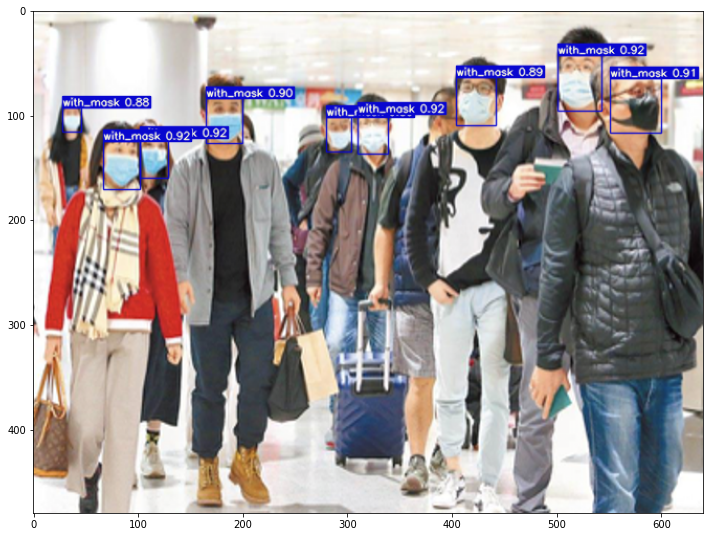

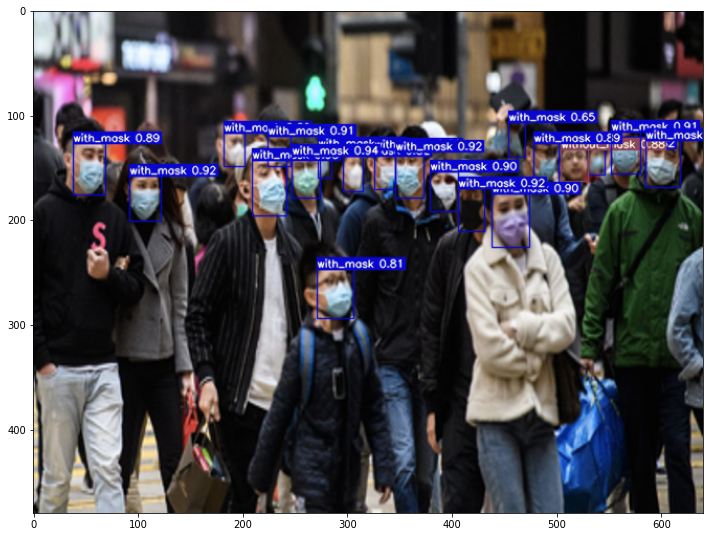

In [ ]:
test_images_path = 'runs/detect/test_images/'
test_images = [*os.listdir(test_images_path)]
for img_path in test_images[:10]:
    img = mpimg.imread(test_images_path+img_path)
    plt.figure(figsize=(12,12))
    plt.imshow(img)

In [ ]:
test_images_path = 'runs/detect/Test_extra/'
test_images = [*os.listdir(test_images_path)]
for img_path in test_images[:10]:
    img = mpimg.imread(test_images_path+img_path)
    plt.figure(figsize=(12,12))
    plt.imshow(img)

# Test on video

In [ ]:
!python ./yolov7/detect.py --weight ./runs/train/yolov7x_results8/weights/best.pt --conf 0.5 --source test_video.mp4 --no-trace

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=True, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='test_video.mp4', update=False, view_img=False, weights=['./runs/train/yolov7x_results8/weights/best.pt'])
YOLOR 🚀 2022-10-8 torch 1.9.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060, 5926.6875MB)

Fusing layers... 
IDetect.fuse
Model Summary: 362 layers, 70795920 parameters, 0 gradients
/home/abdulaziz/anaconda3/envs/w2v/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
video 1/1 (1/4643) /home/abdulaziz/BDAI/Week 6/Day 5/te

video 1/1 (56/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (18.5ms) Inference, (0.7ms) NMS
video 1/1 (57/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (58/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (59/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (60/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (61/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (62/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (63/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (64/4643) /hom

video 1/1 (124/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (125/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (126/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (127/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (128/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (129/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.7ms) NMS
video 1/1 (130/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.7ms) NMS
video 1/1 (131/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (132/4

video 1/1 (188/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (189/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (18.5ms) Inference, (0.7ms) NMS
video 1/1 (190/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (191/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (192/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (193/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (194/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (195/4643) /home/

video 1/1 (247/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (248/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (249/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (250/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (251/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (252/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (253/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.7ms) NMS
video 1/1 (254/4643) /home/

video 1/1 (309/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (310/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (311/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.0ms) Inference, (0.7ms) NMS
video 1/1 (312/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (313/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (314/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (315/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (316/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 4 with_masks, Done. 

video 1/1 (376/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (377/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (378/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (379/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (380/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (381/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.7ms) NMS
video 1/1 (382/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (383/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (384/4

video 1/1 (443/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (444/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (445/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (446/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (447/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.7ms) NMS
video 1/1 (448/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (449/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (450/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 5 with_masks, Done. (17.0ms) Inference, (0.7ms) NMS
video 1/1 (451/4

video 1/1 (512/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (513/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (514/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (515/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (516/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (517/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (518/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (519/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS


video 1/1 (578/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (579/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (580/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.7ms) NMS
video 1/1 (581/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (582/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (583/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (584/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (585/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.0ms) Inference, (0.6ms) NMS


video 1/1 (646/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (647/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (648/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (649/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (650/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.0ms) Inference, (0.6ms) NMS
video 1/1 (651/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (652/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (653/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (654/4643) /ho

video 1/1 (714/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (715/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.7ms) NMS
video 1/1 (716/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (717/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (718/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (719/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (720/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (721/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (722/4643) /ho

video 1/1 (783/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (784/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (785/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (786/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (787/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (788/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (789/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (790/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (791/4643) /ho

video 1/1 (853/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (854/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (855/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (856/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (857/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (858/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (859/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.7ms) NMS
video 1/1 (860/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.5ms) Inference, (0.6ms) NMS
video 1/1 (861/4643) /ho

video 1/1 (922/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (923/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (924/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (925/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (926/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (927/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (928/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (929/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (930/4643) /h

video 1/1 (993/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.1ms) Inference, (0.4ms) NMS
video 1/1 (994/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.1ms) Inference, (0.4ms) NMS
video 1/1 (995/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (18.2ms) Inference, (0.4ms) NMS
video 1/1 (996/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.1ms) Inference, (0.4ms) NMS
video 1/1 (997/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.1ms) Inference, (0.4ms) NMS
video 1/1 (998/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.1ms) Inference, (0.4ms) NMS
video 1/1 (999/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.1ms) Inference, (0.4ms) NMS
video 1/1 (1000/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.1ms) Inference, (0.4ms) NMS
video 1/1 (1001/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.1ms) Inference, (0.4ms) NMS
video 1/1 (1002/4

video 1/1 (1067/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1068/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1069/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1070/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1071/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1072/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1073/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1074/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1075/

video 1/1 (1134/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1135/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1136/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1137/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1138/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1139/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1140/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1141/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1142/

video 1/1 (1201/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1202/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1203/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1204/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1205/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1206/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1207/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1208/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1209/

video 1/1 (1270/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.3ms) Inference, (0.7ms) NMS
video 1/1 (1271/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1272/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1273/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1274/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1275/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1276/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1277/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1278/

video 1/1 (1339/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1340/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1341/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1342/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1343/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1344/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1345/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1346/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1347/

video 1/1 (1407/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1408/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1409/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1410/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1411/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1412/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1413/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1414/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1415/

video 1/1 (1474/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1475/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1476/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1477/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1478/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1479/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1480/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1481/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1482/

video 1/1 (1542/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1543/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1544/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.2ms) Inference, (0.7ms) NMS
video 1/1 (1545/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1546/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1547/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1548/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1549/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1550/

video 1/1 (1609/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1610/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1611/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1612/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1613/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1614/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1615/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1616/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.1ms) Inference, (0.6ms) NMS
video 1/1 (1617/

video 1/1 (1678/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1679/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1680/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1681/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.7ms) NMS
video 1/1 (1682/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.6ms) Inference, (0.7ms) NMS
video 1/1 (1683/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1684/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1685/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1686/

video 1/1 (1746/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1747/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1748/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1749/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1750/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1751/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1752/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1753/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1754/

video 1/1 (1814/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1815/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1816/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1817/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1818/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1819/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.4ms) Inference, (0.7ms) NMS
video 1/1 (1820/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1821/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1822/

video 1/1 (1882/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1883/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1884/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (1885/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (1886/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (1887/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (1888/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (1889/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (1890/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inferen

video 1/1 (1954/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.7ms) NMS
video 1/1 (1955/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.5ms) Inference, (0.6ms) NMS
video 1/1 (1956/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (1957/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1958/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1959/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1960/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1961/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (1962/

video 1/1 (2022/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2023/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2024/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (1.1ms) NMS
video 1/1 (2025/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2026/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2027/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2028/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2029/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2030/

video 1/1 (2091/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2092/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.9ms) Inference, (0.6ms) NMS
video 1/1 (2093/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2094/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2095/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2096/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (2097/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.7ms) NMS
video 1/1 (2098/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2099/

video 1/1 (2159/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2160/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2161/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2162/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2163/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2164/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2165/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2166/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2167/

video 1/1 (2227/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2228/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2229/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (18.6ms) Inference, (0.1ms) NMS
video 1/1 (2230/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2231/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2232/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2233/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2234/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2235/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 

video 1/1 (2297/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (2298/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2299/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2300/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2301/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2302/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2303/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2304/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (2305/

video 1/1 (2364/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.4ms) Inference, (0.6ms) NMS
video 1/1 (2365/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.5ms) Inference, (0.6ms) NMS
video 1/1 (2366/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2367/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2368/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2369/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2370/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2371/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.7ms) NMS
video 1/1 (2372/

video 1/1 (2431/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2432/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2433/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2434/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2435/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.7ms) NMS
video 1/1 (2436/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2437/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2438/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (2439/

video 1/1 (2503/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (18.6ms) Inference, (0.2ms) NMS
video 1/1 (2504/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2505/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2506/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2507/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.3ms) Inference, (0.2ms) NMS
video 1/1 (2508/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.3ms) Inference, (0.1ms) NMS
video 1/1 (2509/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.2ms) NMS
video 1/1 (2510/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2511/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.2ms) NMS
video 1/1 

video 1/1 (2575/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2576/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (2577/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2578/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2579/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2580/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2581/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2582/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2583/

video 1/1 (2647/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2648/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2649/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2650/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2651/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2652/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2653/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2654/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (2655/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 

video 1/1 (2718/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (2719/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2720/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2721/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2722/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2723/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.5ms) Inference, (0.6ms) NMS
video 1/1 (2724/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.5ms) Inference, (0.6ms) NMS
video 1/1 (2725/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2726/

video 1/1 (2789/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2790/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2791/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (2792/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2793/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2794/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2795/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2796/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2797/

video 1/1 (2858/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2859/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2860/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2861/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2862/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2863/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.7ms) NMS
video 1/1 (2864/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2865/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2866/

video 1/1 (2925/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2926/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2927/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2928/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2929/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2930/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2931/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (2932/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2933/

video 1/1 (2992/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2993/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2994/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2995/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2996/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2997/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2998/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (2999/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3000/

video 1/1 (3059/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3060/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3061/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3062/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3063/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3064/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3065/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3066/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3067/

video 1/1 (3126/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.4ms) Inference, (0.6ms) NMS
video 1/1 (3127/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3128/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3129/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3130/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3131/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3132/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3133/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3134/

video 1/1 (3195/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3196/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3197/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3198/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3199/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3200/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3201/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3202/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3203/

video 1/1 (3263/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3264/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3265/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3266/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3267/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3268/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3269/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3270/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3271/

video 1/1 (3332/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3333/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3334/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3335/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3336/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3337/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3338/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3339/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3340/

video 1/1 (3401/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3402/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3403/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3404/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3405/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3406/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3407/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3408/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1

video 1/1 (3468/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3469/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3470/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3471/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3472/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3473/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3474/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3475/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/

video 1/1 (3536/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3537/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3538/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3539/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3540/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3541/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3542/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3543/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/

video 1/1 (3603/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3604/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3605/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3606/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3607/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3608/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3609/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3610/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/

video 1/1 (3671/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3672/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3673/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3674/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3675/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3676/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3677/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3678/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3679

video 1/1 (3739/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3740/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3741/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3742/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3743/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3744/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (1.3ms) NMS
video 1/1 (3745/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (18.4ms) Inference, (0.9ms) NMS
video 1/1 (3746/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1

video 1/1 (3807/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3808/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3809/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3810/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3811/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3812/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3813/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3814/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/

video 1/1 (3874/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.9ms) NMS
video 1/1 (3875/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3876/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (18.8ms) Inference, (0.7ms) NMS
video 1/1 (3877/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3878/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3879/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (3880/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 3 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3881/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 2 with_masks, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/

video 1/1 (3943/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3944/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3945/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3946/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3947/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3948/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3949/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (3950/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6

video 1/1 (4010/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (18.6ms) Inference, (0.6ms) NMS
video 1/1 (4011/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4012/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4013/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4014/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (4015/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4016/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4017/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 without_mask, Done. (17.2ms) Inference, (0.6

video 1/1 (4078/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4079/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4080/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4081/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4082/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4083/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4084/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4085/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4086/

video 1/1 (4145/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.5ms) Inference, (0.8ms) NMS
video 1/1 (4146/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4147/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4148/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4149/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4150/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4151/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4152/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4153/

video 1/1 (4213/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4214/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4215/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4216/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (4217/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4218/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4219/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4220/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (4221/

video 1/1 (4281/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (18.7ms) Inference, (0.6ms) NMS
video 1/1 (4282/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4283/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4284/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4285/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4286/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (4287/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (4288/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: Done. (17.2ms) Inference, (0.1ms) NMS
video 1/1 (4289/4643) /home/abdulaziz/BDAI/Week 6/Day 5

video 1/1 (4351/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4352/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4353/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4354/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4355/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4356/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4357/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4358/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4359/

video 1/1 (4418/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4419/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4420/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4421/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4422/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4423/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (4424/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4425/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4426/

video 1/1 (4485/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4486/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4487/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4488/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4489/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4490/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4491/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4492/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4493/

video 1/1 (4552/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4553/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4554/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4555/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4556/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4557/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.3ms) Inference, (0.6ms) NMS
video 1/1 (4558/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4559/4643) /home/abdulaziz/BDAI/Week 6/Day 5/test_video.mp4: 1 with_mask, Done. (17.2ms) Inference, (0.6ms) NMS
video 1/1 (4560/

In [ ]:
HTML('<iframe width="960" height="540" src="runs/detect/exp2/test_video.mp4" frameborder="0" allowfullscreen></iframe>')